In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras import layers, models


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
BATCH_SIZE=2048
EPOCHS=10

In [4]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def evaluate_given_keras_model(model_builder, scheduler=None, folds=5, prefix="data_no_features/fold_", 
                                epochs=EPOCHS, batch_size=BATCH_SIZE, thresholds=[0.5], verbose=0):
    auc_scores = []
    all_y_true = []
    all_y_pred_prob = []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []

    fold_preds = []
    fold_trues = []

    for i in range(folds):
        train = pd.read_csv(f"{prefix}{i+1}_train_no_features.csv")
        test = pd.read_csv(f"{prefix}{i+1}_test_no_features.csv")

        train.iloc[:, 0] = train.iloc[:, 0].apply(lambda x: 1 if x > 1 else x)
        test.iloc[:, 0] = test.iloc[:, 0].apply(lambda x: 1 if x > 1 else x)

        X_train = train.iloc[:, 1:].values
        y_train = train.iloc[:, 0].values
        X_test = test.iloc[:, 1:].values
        y_test = test.iloc[:, 0].values

        model = model_builder(X_train.shape[1])
        callbacks = [scheduler] if scheduler else []

        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                  verbose=verbose, callbacks=callbacks, validation_data=(X_test, y_test))

        y_pred_prob = model.predict(X_test).ravel()
        all_y_pred_prob.extend(y_pred_prob)
        all_y_true.extend(y_test)

        fold_preds.append(y_pred_prob)
        fold_trues.append(y_test)

        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        auc_scores.append(auc(fpr, tpr))

    all_y_true = np.array(all_y_true)
    all_y_pred_prob = np.array(all_y_pred_prob)
    mean_auc = np.mean(auc_scores)

    print("\nWyniki dla różnych wartości threshold:")
    for thresh in thresholds:
        metryki = {
            'acc': [], 'f1': [], 'precision': [], 'sensitivity': [], 'specificity': [],
            'mcc': [], 'nMCC': [], 'fc': [],
            'tp': [], 'fp': [], 'tn': [], 'fn': []
        }

        for y_true, y_pred_prob in zip(fold_trues, fold_preds):
            y_pred = (y_pred_prob >= thresh).astype(int)
            cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
            tn, fp, fn, tp = cm.ravel()

            acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
            prec = tp / (tp + fp) if (tp + fp) > 0 else 0
            sens = tp / (tp + fn) if (tp + fn) > 0 else 0
            spec = tn / (tn + fp) if (tn + fp) > 0 else 0
            f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

            denom = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
            mcc = ((tp * tn) - (fp * fn)) / denom if denom > 0 else 0
            n_mcc = (mcc + 1) / 2
            fc = 0.5 * f1 + 0.3 * spec + 0.2 * n_mcc

            # Zbieranie metryk
            metryki['acc'].append(acc)
            metryki['f1'].append(f1)
            metryki['precision'].append(prec)
            metryki['sensitivity'].append(sens)
            metryki['specificity'].append(spec)
            metryki['mcc'].append(mcc)
            metryki['nMCC'].append(n_mcc)
            metryki['fc'].append(fc)
            metryki['tp'].append(tp)
            metryki['fp'].append(fp)
            metryki['tn'].append(tn)
            metryki['fn'].append(fn)

        def mean_std(lst):
            return f"{np.mean(lst):.2f} ± {np.std(lst):.2f}"

        print(f"\nThreshold = {thresh}")
        print(f"Accuracy:     {mean_std(metryki['acc'])}")
        print(f"F1-score:     {mean_std(metryki['f1'])}")
        # print(f"Precision:    {mean_std(metryki['precision'])}")
        # print(f"Sensitivity:  {mean_std(metryki['sensitivity'])}")
        print(f"Specificity:  {mean_std(metryki['specificity'])}")
        # print(f"MCC:          {mean_std(metryki['mcc'])}")
        print(f"nMCC:         {mean_std(metryki['nMCC'])}")
        print(f"Funkcja celu: {mean_std(metryki['fc'])}")
        # print(f"TP:           {mean_std(metryki['tp'])}")
        # print(f"FP:           {mean_std(metryki['fp'])}")
        # print(f"TN:           {mean_std(metryki['tn'])}")
        # print(f"FN:           {mean_std(metryki['fn'])}")

    print(f"\nŚredni AUC = {mean_auc:.2f}")
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    plt.figure(figsize=(8, 6))
    plt.plot(mean_fpr, mean_tpr,)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Średnia krzywa ROC (5-fold)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

## DENSE

284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Wyniki dla różnych wartości threshold:

Threshold = 0.3
Accuracy:     0.77 ± 0.01
F1-score:     0.83 ± 0.01
Specificity:  0.47 ± 0.06
nMCC:         0.76 ± 0.01
Funkcja celu: 0.71 ± 0.02

Threshold = 0.5
Accuracy:     0.79 ± 0.01
F1-score:     0.84 ± 0.01
Specificity:  0.61 ± 0.07
nMCC:         0.77 ± 0.01
Funkcja celu: 0.76 ± 0.02

Threshold = 0.7
Accuracy:     0.77 ± 0.02
F1-score:     0.81 ± 0.02
Specificity:  0.74 ± 0.05
nMCC:         0.77 ± 0.01
Funkcja celu: 0.78 ± 0.01

Średni AUC = 0.85


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


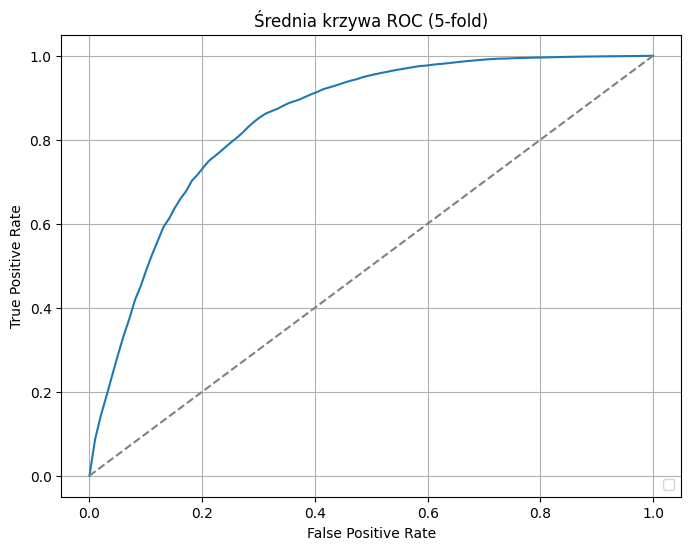

In [9]:
def custom_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

def build_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
    layers.Dense(1024, activation='relu'), 
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'), 
    layers.Dense(1, activation='sigmoid') 
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

scheduler = LearningRateScheduler(custom_scheduler)
evaluate_given_keras_model(build_model,thresholds=[0.3, 0.5, 0.7], scheduler=scheduler)

## CNN

284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Wyniki dla różnych wartości threshold:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.




Threshold = 0.3
Accuracy:     0.76 ± 0.01
F1-score:     0.83 ± 0.01
Specificity:  0.45 ± 0.05
nMCC:         0.75 ± 0.01
Funkcja celu: 0.70 ± 0.02

Threshold = 0.5
Accuracy:     0.78 ± 0.01
F1-score:     0.83 ± 0.00
Specificity:  0.61 ± 0.07
nMCC:         0.77 ± 0.01
Funkcja celu: 0.75 ± 0.02

Threshold = 0.7
Accuracy:     0.77 ± 0.01
F1-score:     0.80 ± 0.02
Specificity:  0.74 ± 0.05
nMCC:         0.76 ± 0.01
Funkcja celu: 0.77 ± 0.01

Średni AUC = 0.84


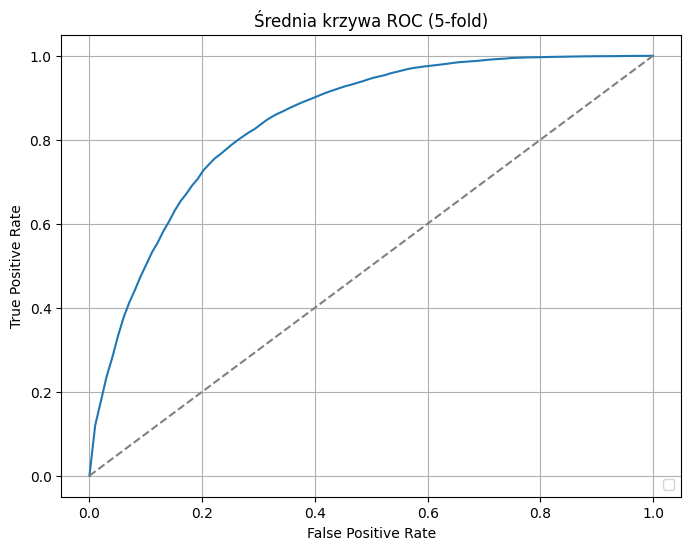

In [10]:
def custom_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

def build_model(input_dim):
    model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Reshape((input_dim, 1)), 
    layers.Conv1D(64, (3), activation='relu'),
    layers.MaxPooling1D((2)),
    layers.Conv1D(32, (3), activation='relu'),
    layers.MaxPooling1D((2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

scheduler = LearningRateScheduler(custom_scheduler)
evaluate_given_keras_model(build_model,thresholds=[0.3, 0.5, 0.7], scheduler=scheduler)

## CNN-LSTM

284/284 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step
287/287 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step
285/285 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step
286/286 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step

Wyniki dla różnych wartości threshold:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.




Threshold = 0.3
Accuracy:     0.61 ± 0.00
F1-score:     0.75 ± 0.00
Specificity:  0.00 ± 0.00
nMCC:         0.50 ± 0.00
Funkcja celu: 0.48 ± 0.00

Threshold = 0.5
Accuracy:     0.61 ± 0.00
F1-score:     0.75 ± 0.00
Specificity:  0.00 ± 0.00
nMCC:         0.50 ± 0.00
Funkcja celu: 0.48 ± 0.00

Threshold = 0.7
Accuracy:     0.58 ± 0.10
F1-score:     0.62 ± 0.27
Specificity:  0.29 ± 0.37
nMCC:         0.52 ± 0.08
Funkcja celu: 0.50 ± 0.09

Średni AUC = 0.50


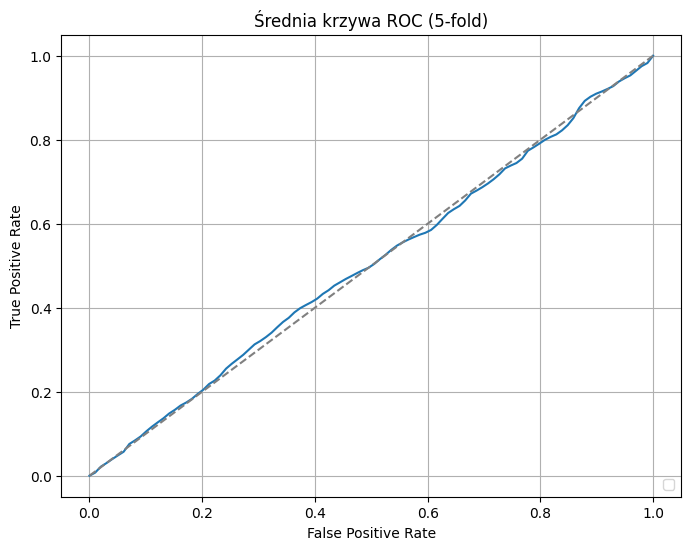

In [5]:
def custom_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

def build_model(input_dim):
    model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Reshape((input_dim, 1)), 
    layers.Conv1D(64, (3), activation='relu'),
    layers.MaxPooling1D((2)),
    # layers.Flatten(),
    layers.LSTM(64),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid')
])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

scheduler = LearningRateScheduler(custom_scheduler)
evaluate_given_keras_model(build_model,thresholds=[0.3, 0.5, 0.7], scheduler=scheduler)

## LSTM

In [ ]:
def custom_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

def build_model(input_dim):
    model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Reshape((input_dim, 1)), 
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64, return_sequences=False),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') 
])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

scheduler = LearningRateScheduler(custom_scheduler)
evaluate_given_keras_model(build_model,thresholds=[0.3, 0.5, 0.7], scheduler=scheduler,verbose=1)

284/284 ━━━━━━━━━━━━━━━━━━━━ 44s 155ms/step
280/280 ━━━━━━━━━━━━━━━━━━━━ 40s 143ms/step


KeyboardInterrupt: 